In [1]:
import geopandas
import numpy as np
import pandas as pd
import contextily as cx
from matplotlib import pyplot as plt
import osmnx as ox
import algo
import os
import pickle

In [2]:
df_population = pd.read_excel("test_data.xlsx", sheet_name="Population").rename(columns={"lon": "long"})
df_store = pd.read_excel("test_data.xlsx", sheet_name="Stores").rename(columns={"Metric Store": "metric store"})

population = df_population[["long", "lat"]].to_numpy()
stores = df_store[["long", "lat"]].to_numpy()

route_neighbours_dict = pickle.load(open("saved_data/route_neighbours", "rb"))
route_neighbours_dist = np.array([v[1] for v in route_neighbours_dict.values()])
route_neighbours = np.array([v[0] for v in route_neighbours_dict.values()])

# I want to suggest a location for a new store such that the overall traveled delivery distance is minimized. 
### As I can't change locations of current stores, I want to build a store for customers that:
 - for which the delivery distance is high for the current configuration
 - these customers are located in proximity one to another    
 - there are enough customers that a new store can service
### Translating it to mathematical language:
 - Filter customers with high delivery distance
 - Cluster them by spatial proximity
 - Chose large enough clusters
### The final step will be to test the suggested locations and chose one with the smallest total travel distance

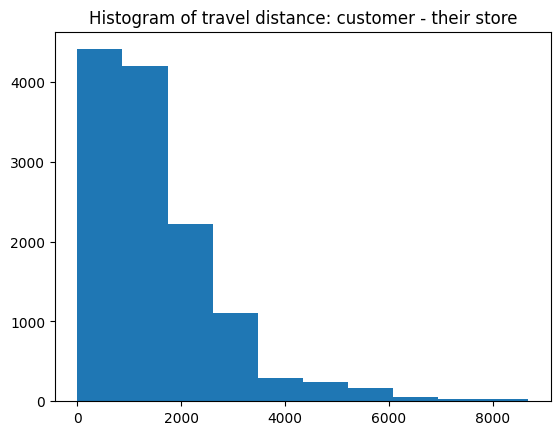

In [3]:
plt.hist(route_neighbours_dist)
plt.title("Histogram of travel distance: customer - their store")
plt.show()

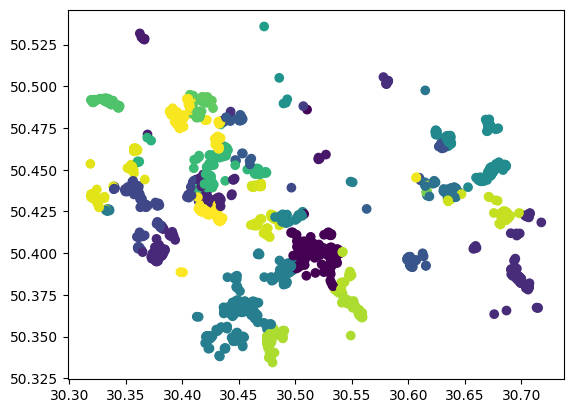

In [4]:
# df_population["dist_to_store"] = route_neighbours_dist
dist_mask = route_neighbours_dist > 2500
plt.scatter(population[dist_mask, 0], population[dist_mask, 1], c=route_neighbours[dist_mask])
plt.show()

In [5]:
print(f"{round(dist_mask.mean()*100, 2)} % of costumers are considered to be reasigned to a new store")

16.33 % of costumers are considered to be reasigned to a new store


# Clustering
### The clustering will be performed using euclidian metric for simplicity, the final evaluation will be done by routing distance
### I chose to start with OPTICS as it determines number of clusters automatically and removes outliers

In [6]:
X = population[dist_mask]

from sklearn.cluster import OPTICS

sizes of classes[116 212 141 394 129 112]


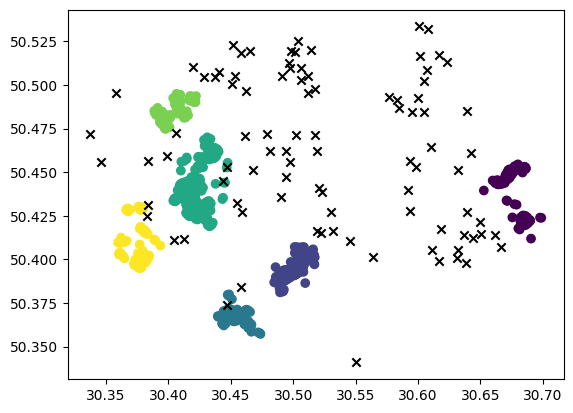

In [7]:
clustering = OPTICS(min_samples=100, p=2).fit(X)
optic_labels = clustering.labels_
optic_labels1 = optic_labels[optic_labels!=-1]
print(f"sizes of classes{np.unique(optic_labels1, return_counts=True)[1]}")

X_filt = X[optic_labels!=-1]
plt.scatter(X_filt[:, 0], X_filt[:, 1], c=optic_labels1)
plt.scatter(stores[:, 0], stores[:, 1], c='k', marker='x')
plt.show()

sizes of classes[319 393]


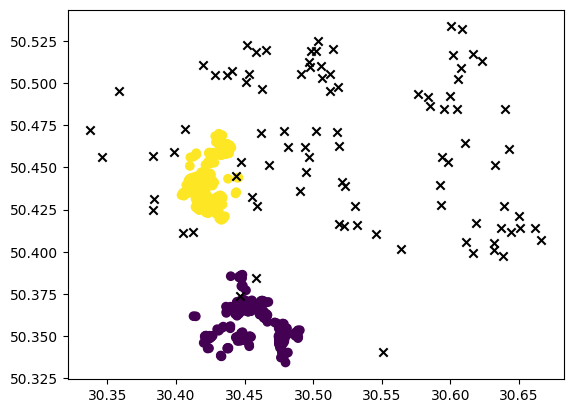

In [8]:
clustering = OPTICS(min_samples=150, p=2).fit(X)
optic_labels = clustering.labels_
optic_labels2 = optic_labels[optic_labels!=-1]
print(f"sizes of classes{np.unique(optic_labels2, return_counts=True)[1]}")

X_filt = X[optic_labels!=-1]
plt.scatter(X_filt[:, 0], X_filt[:, 1], c=optic_labels2)
plt.scatter(stores[:, 0], stores[:, 1], c='k', marker='x')
plt.show()

### If our goal is to reduce delivery distance, then the most optimal choice is to use one of the two clusters of second model of Optics, as they are the largest and both of them far from current stores

In [9]:
store1_long = np.median(X_filt[optic_labels2==0][:, 0])
store1_lat = np.median(X_filt[optic_labels2==0][:, 1])

store2_long = np.median(X_filt[optic_labels2==1][:, 0])
store2_lat = np.median(X_filt[optic_labels2==1][:, 1])

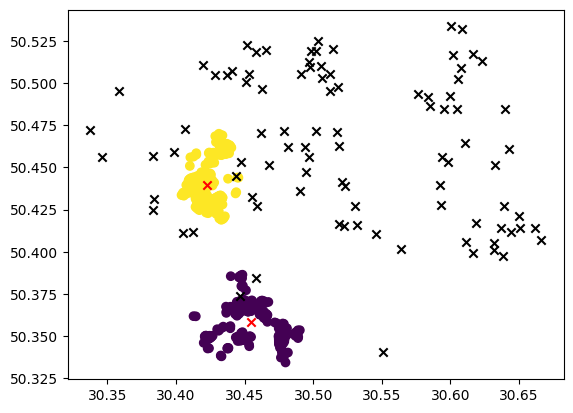

In [10]:
plt.scatter(X_filt[:, 0], X_filt[:, 1], c=optic_labels2)
plt.scatter([store1_long, store2_long], [store1_lat, store2_lat], c='red', marker='x')
plt.scatter(stores[:, 0], stores[:, 1], c='k', marker='x')
plt.show()

In [11]:
place = "Kyiv, Ukraine"
G_map = ox.graph_from_place(place, network_type="drive")

### The following is complete procedure of reasignment of the closest store for each customer (it is not necessary to perform complete reassignment, but I do it here for simplicity)

In [12]:
route_neighbours_dict1 = algo.iterate_new_store(store1_long, store1_lat, "route_neighbours_store1", G_map, stores=stores, population=population)

In [13]:
route_neighbours_dict2 = algo.iterate_new_store(store2_long, store2_lat, "route_neighbours_store2", G_map, stores=stores, population=population)

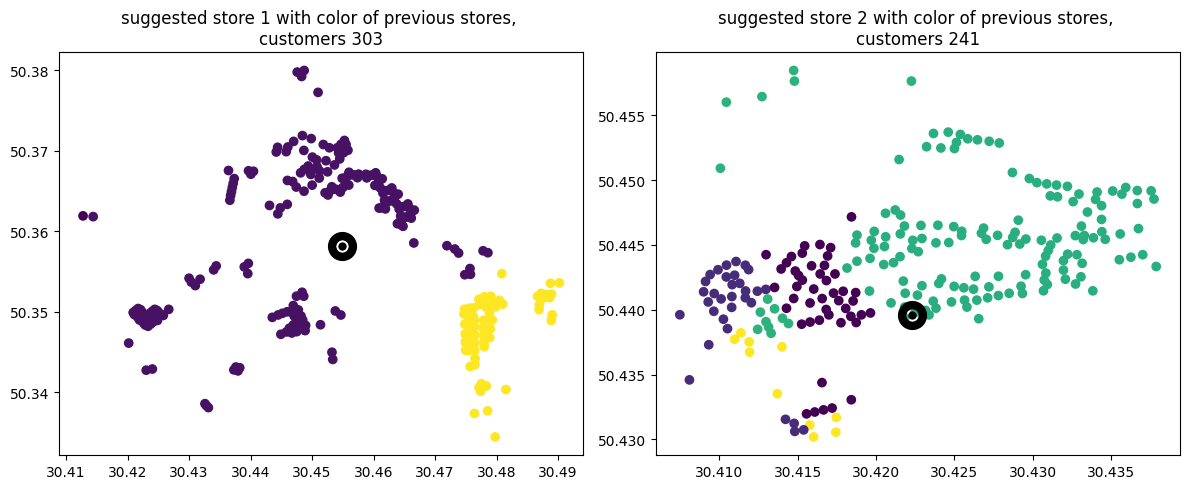

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
num_customers1 = (np.array([v[0] for v in route_neighbours_dict1.values()])==92).sum()
new_store1_mask = (np.array([v[0] for v in route_neighbours_dict1.values()])==92)
plt.scatter(population[new_store1_mask, 0], population[new_store1_mask, 1], c=route_neighbours[new_store1_mask])
plt.scatter([store1_long], [store1_lat], c='black', marker='o', lw=15)
plt.title(f"suggested store 1 with color of previous stores, \ncustomers {num_customers1}")
plt.subplot(122)
num_customers2 = (np.array([v[0] for v in route_neighbours_dict2.values()])==92).sum()
new_store2_mask = (np.array([v[0] for v in route_neighbours_dict2.values()])==92)
plt.scatter(population[new_store2_mask, 0], population[new_store2_mask, 1], c=route_neighbours[new_store2_mask])
plt.scatter([store2_long], [store2_lat], c='black', marker='o', lw=15)
plt.title(f"suggested store 2 with color of previous stores, \ncustomers {num_customers2}")
plt.tight_layout()
plt.show()

In [15]:
route_neighbours_dist1 = np.array([v[1] for v in route_neighbours_dict1.values()])
sum1 = route_neighbours_dist[new_store1_mask].sum()
sum1_new = route_neighbours_dist1[new_store1_mask].sum()
avg1 = sum1/num_customers1
avg1_new = sum1_new/num_customers1
tot1 = sum1 - sum1_new


print(f"average distance for {num_customers1} customers was {round(avg1, 2)}, if we open Store2, it will be {round(avg1_new, 2)}\n"
      f"Total economy is ~ {tot1//1000} km")

average distance for 303 customers was 5443.02, if we open Store2, it will be 3086.99
Total economy is ~ 713.0 km


In [16]:
route_neighbours_dist2 = np.array([v[1] for v in route_neighbours_dict2.values()])
sum2 = route_neighbours_dist[new_store2_mask].sum()
sum2_new = route_neighbours_dist2[new_store2_mask].sum()
avg2 = sum2/num_customers2
avg2_new = sum2_new/num_customers2
tot2 = sum2 - sum2_new


print(f"average distance for {num_customers2} customers was {round(avg2, 2)} m, if we open Store2, it will be {round(avg2_new, 2)} m\n"
      f"Total economy is ~ {tot2//1000} km")

average distance for 241 customers was 2977.36 m, if we open Store2, it will be 1488.74 m
Total economy is ~ 358.0 km


### The first store is obviously a better choice if our goal is to reduce delivery distance
# Final store location

In [17]:
new_store = pd.DataFrame([[store1_long, store1_lat]], columns=["long", "lat"])
new_store

,long,lat
0,30.454893,50.358203


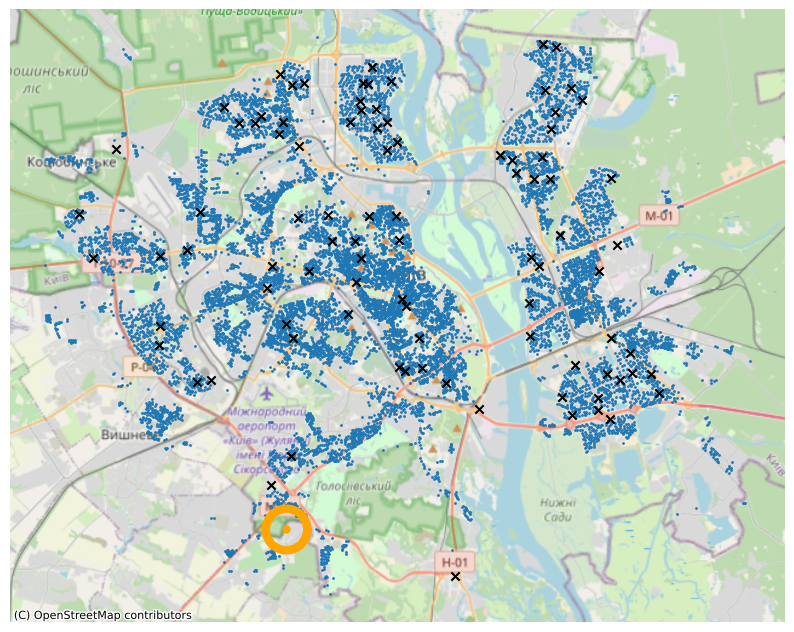

In [18]:
df_new_store_geo = geopandas.GeoDataFrame(new_store, geometry=geopandas.points_from_xy(new_store["long"], new_store["lat"]), crs='EPSG:4326').to_crs(epsg=9821)
df_store_geo = geopandas.GeoDataFrame(df_store, geometry=geopandas.points_from_xy(df_store["long"], df_store["lat"]), crs='EPSG:4326').to_crs(epsg=9821)
df_population_geo = geopandas.GeoDataFrame(df_population, geometry=geopandas.points_from_xy(df_population["long"], df_population["lat"]), crs='EPSG:4326').to_crs(epsg=9821)

fig, ax = plt.subplots(figsize=(10, 10))
ax = df_population_geo.plot(ax=ax, markersize=1)
ax = df_store_geo.plot(ax=ax, color="k", marker='x')
ax = df_new_store_geo.plot(ax=ax, color="orange", marker='o', lw=30)
cx.add_basemap(ax, crs=df_store_geo.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

In [19]:
place = "Kyiv, Ukraine"
G = ox.graph_from_place(place, network_type="drive")
store2_node = algo.get_network_node((store1_long, store1_lat), G)

In [20]:
store2_node

684475240

In [21]:
ox.graph_to_gdfs(G, edges=True, nodes=False).loc[[store2_node]].to_crs(epsg=9821)

osmid  oneway lanes  \
u         v          key                                       
684475240 2925265985 0    [906088554, 4423654]    True     3   
          684475239  0               731000580   False     2   

                                                 name       highway maxspeed  \
u         v          key                                                       
684475240 2925265985 0    проспект Академіка Глушкова         trunk       50   
          684475239  0                            NaN  unclassified       20   

                         reversed   length  \
u         v          key                     
684475240 2925265985 0      False  315.476   
          684475239  0       True   40.405   

                                                                   geometry  \
u         v          key                                                      
684475240 2925265985 0    LINESTRING (296424.745 5581389.897, 296229.280...   
          684475239  0    LINESTRING (296424.745 5581389.897, 296401.807...   

                         access bridge   ref junction tunnel width est_width  
u         v          key                                                      
684475240 2925265985 0      NaN    NaN  М-05      NaN    NaN   NaN       NaN  
          684475239  0      NaN    NaN   NaN      NaN    NaN   NaN       NaN

# According to Google Map it would be in this area:

![new store Google Maps](new_store_google_maps.png)